<a href="https://colab.research.google.com/github/FarrelAD/Tim-Maju-Lancar-Datathon-Jatim-2025/blob/dev%2Fcakra/dataslbjatim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
sns.set(style="whitegrid")

In [ ]:
file_path_candidates = [
    '/mnt/data/jatim-csv-lengkap.csv',
    'jatim-csv-lengkap.csv'
]

df = None
for p in file_path_candidates:
    try:
        df = pd.read_csv(p)
        print(f"Loaded: {p}")
        break
    except Exception as e:
        pass

if df is None:
    try:
        from google.colab import files
        uploaded = files.upload()
        filename = list(uploaded.keys())[0]
        # Assuming the uploaded file is an Excel file based on the output
        df = pd.read_excel(filename)
        print(f"Loaded via upload: {filename}")
    except Exception as e:
        raise RuntimeError("Gagal memuat data. Pastikan file 'jatim-csv.csv' atau 'jatim-excel-lengkap.xlsx' tersedia atau upload manual.")

print("Ukuran data:", df.shape)
print("Kolom:", list(df.columns)[:15], "...")

Saving jatim-excel-lengkap.xlsx to jatim-excel-lengkap.xlsx
Loaded via upload: jatim-excel-lengkap.xlsx
Ukuran data: (392, 103)
Kolom: ['kabupaten/kota', 'kecamatan', 'sekolah', 'rombel', 'sekolah_id', 'npsn', 'bentuk_pendidikan', 'status_sekolah', 'akreditasi', 'guru_kelas', 'guru_matematika', 'guru_bahasa_indonesia', 'guru_bahasa_inggris', 'guru_sejarah_indonesia', 'guru_pkn'] ...


In [ ]:
# ============================================================
# 1) DATA PREP: STANDARISASI KUNCI, DERIVASI KOL0M
# ============================================================
# Nama kolom minimal yang dipakai
# - 'kabupaten/kota'
# - 'kecamatan'
# - 'sekolah'
# - 'pd' (total siswa) atau 'pd_laki' + 'pd_perempuan'
# - 'ptk' (total guru) atau 'ptk_laki' + 'ptk_perempuan' atau sum kolom guru_*
required_keys = ['kabupaten/kota', 'sekolah']

for k in required_keys:
    if k not in df.columns:
        raise ValueError(f"Kolom wajib '{k}' tidak ditemukan di data.")

# Siapkan kolom siswa total
if 'pd' in df.columns:
    df['students'] = df['pd']
else:
    # fallback jika ada pd_laki/pd_perempuan
    cols = [c for c in df.columns if c.lower() in ['pd_laki', 'pd_perempuan']]
    if set(['pd_laki', 'pd_perempuan']).issubset(df.columns):
        df['students'] = df['pd_laki'] + df['pd_perempuan']
    else:
        raise ValueError("Tidak ditemukan 'pd' atau kombinasi 'pd_laki' + 'pd_perempuan'.")

# Siapkan kolom guru total
if 'ptk' in df.columns:
    df['teachers'] = df['ptk']
else:
    # fallback ke ptk_laki + ptk_perempuan
    if set(['ptk_laki', 'ptk_perempuan']).issubset(df.columns):
        df['teachers'] = df['ptk_laki'] + df['ptk_perempuan']
    else:
        # fallback terakhir: jumlahkan semua kolom yang diawali 'guru_'
        guru_cols = [c for c in df.columns if c.startswith('guru_')]
        if len(guru_cols) > 0:
            df['teachers'] = df[guru_cols].fillna(0).sum(axis=1)
        else:
            raise ValueError("Tidak ditemukan 'ptk' / 'ptk_laki+ptk_perempuan' / kolom 'guru_*'.")

# Hindari nilai negatif/NaN
df['students'] = df['students'].fillna(0).clip(lower=0)
df['teachers'] = df['teachers'].fillna(0).clip(lower=0)

# Rasio per sekolah (siswa/guru) – jika teachers=0, set NaN (nanti ditangani)
df['ratio_school'] = df.apply(lambda r: np.nan if r['teachers'] == 0 else r['students'] / r['teachers'], axis=1)

# Klasifikasi tipe wilayah (perkotaan jika nama mulai "Kota", lainnya "Kabupaten")
def classify_region(name):
    name = str(name)
    if name.strip().lower().startswith('kota'):
        return 'Perkotaan'
    return 'Kabupaten'
df['tipe_wilayah'] = df['kabupaten/kota'].apply(classify_region)

# Deteksi kolom fasilitas before/after secara dinamis
before_cols = [c for c in df.columns if c.startswith('before_')]
after_cols  = [c for c in df.columns if c.startswith('after_')]

# Hitung total fasilitas per sekolah (before & after)
if len(before_cols) > 0:
    df['facility_before_sum'] = df[before_cols].fillna(0).sum(axis=1)
else:
    df['facility_before_sum'] = 0

if len(after_cols) > 0:
    df['facility_after_sum'] = df[after_cols].fillna(0).sum(axis=1)
else:
    df['facility_after_sum'] = 0

# Indeks fasilitas per sekolah: gunakan nilai "after" (semakin tinggi = fasilitas lebih banyak)
df['facility_index_school'] = df['facility_after_sum']  # simple count index

In [ ]:
# ============================================================
# 2) ANALISIS LEVEL KABUPATEN/KOTA (AGREGAT)
# ============================================================
agg = df.groupby('kabupaten/kota').agg(
    num_schools = ('sekolah', 'count'),
    students    = ('students', 'sum'),
    teachers    = ('teachers', 'sum'),
    median_ratio= ('ratio_school', 'median'),
    mean_ratio  = ('ratio_school', 'mean'),
    facility_index_mean = ('facility_index_school', 'mean'),
    facility_index_median = ('facility_index_school', 'median')
).reset_index()

# Ketimpangan internal (disparitas) antar sekolah di dalam kab/kota
# Koefisien variasi (cv) = std/mean; tambahkan guard utk mean=0
ratio_stats = df.groupby('kabupaten/kota')['ratio_school'].agg(['mean','std']).rename(columns={'mean':'ratio_mean_sch','std':'ratio_std_sch'})
ratio_stats['ratio_cv_sch'] = ratio_stats.apply(lambda r: np.nan if pd.isna(r['ratio_std_sch']) or r['ratio_mean_sch'] in [0, np.nan]
                                                else r['ratio_std_sch']/r['ratio_mean_sch'], axis=1)

fac_stats = df.groupby('kabupaten/kota')['facility_index_school'].agg(['mean','std']).rename(columns={'mean':'fac_mean_sch','std':'fac_std_sch'})
fac_stats['fac_cv_sch'] = fac_stats.apply(lambda r: np.nan if pd.isna(r['fac_std_sch']) or r['fac_mean_sch'] in [0, np.nan]
                                          else r['fac_std_sch']/r['fac_mean_sch'], axis=1)

agg = agg.merge(ratio_stats[['ratio_cv_sch']], left_on='kabupaten/kota', right_index=True, how='left')
agg = agg.merge(fac_stats[['fac_cv_sch']], left_on='kabupaten/kota', right_index=True, how='left')

# Kebutuhan guru tambahan di tingkat kabupaten (agregat)
IDEAL = 8  # 1 guru per 8 siswa (rasio siswa/guru)
agg['needed_teachers_region'] = np.ceil(agg['students']/IDEAL - agg['teachers'])
agg['needed_teachers_region'] = agg['needed_teachers_region'].apply(lambda x: int(x) if x > 0 else 0)


In [ ]:
# ============================================================
# 3) ANALISIS LEVEL SEKOLAH (DETAIL PEMERATAAN)
# ============================================================
# Kebutuhan guru per sekolah
df['needed_teachers_school'] = np.ceil(df['students']/IDEAL - df['teachers'])
df['needed_teachers_school'] = df['needed_teachers_school'].apply(lambda x: int(x) if x > 0 else 0)

# Surplus guru per sekolah (indikasi bisa direalokasi)
# surplus = guru aktual - kebutuhan ideal (students/8)
df['surplus_teachers_school'] = np.floor(df['teachers'] - df['students']/IDEAL)
df['surplus_teachers_school'] = df['surplus_teachers_school'].apply(lambda x: int(x) if x > 0 else 0)

# Skor risiko sekolah untuk pemeringkatan prioritas (gabungan 3 indikator):
# - Rasio tinggi (buruk) -> z-score positif
# - Siswa banyak (buruk) -> z-score positif
# - Fasilitas rendah (buruk) -> z-score negatif dari facility_index
def zscore(s):
    return (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) not in [0, np.nan] else 1)

# Siapkan kolom pembobotan yang aman (hindari NaN)
tmp = df.copy()
tmp['ratio_school_filled'] = tmp['ratio_school'].fillna(tmp['ratio_school'].median())
tmp['facility_index_school_filled'] = tmp['facility_index_school'].fillna(tmp['facility_index_school'].median())

z_ratio = zscore(tmp['ratio_school_filled'])
z_students = zscore(tmp['students'])
z_facility_inv = -zscore(tmp['facility_index_school_filled'])  # dibalik: fasilitas rendah = skor lebih besar

# Bobot bisa disesuaikan; di sini setara
w_ratio, w_students, w_fac = 0.4, 0.4, 0.2
df['risk_score_school'] = (w_ratio*z_ratio + w_students*z_students + w_fac*z_facility_inv)

# TOP 10 sekolah paling butuh intervensi
top10_schools = df.sort_values('risk_score_school', ascending=False).head(10)
print("\nTOP 10 Sekolah Prioritas (skor risiko tertinggi):")
print(top10_schools[['kabupaten/kota','kecamatan','sekolah','students','teachers','ratio_school','facility_index_school','needed_teachers_school','risk_score_school']])



TOP 10 Sekolah Prioritas (skor risiko tertinggi):
       kabupaten/kota        kecamatan                          sekolah  \
301  Kab. Tulungagung      Kec. Ngunut             SLB PGRI AMONG PUTRA   
291        Kab. Tuban       Kec. Tuban  SLB AC JATI WIYATA DHARMA TUBAN   
85        Kab. Jember     Kec. Kalisat              SLB HARAPAN PELANGI   
339       Kota Malang       Kec. Sukun                 SLB BHAKTI LUHUR   
230     Kab. Pasuruan     Kec. Pandaan                     SLBN PANDAAN   
173       Kab. Malang      Kec. Jabung                SLB AL FIRMA`UNAH   
21    Kab. Banyuwangi     Kec. Genteng               SMALB PGRI GENTENG   
202      Kab. Nganjuk     Kec. Loceret        SLB KRIDA UTAMA 2 LOCERET   
37    Kab. Banyuwangi   Kec. Rogojampi               SLB PGRI ROGOJAMPI   
300  Kab. Tulungagung  Kec. Kedungwaru            SLB - PGRI KEDUNGWARU   

     students  teachers  ratio_school  facility_index_school  \
301        88         3     29.333333                      

In [ ]:
# ============================================================
# 4) PRIORITAS INTERVENSI DI LEVEL KABUPATEN (VERSI LEBIH KUAT)
#    Tambahkan komponen ketimpangan (CV) ke dalam penilaian
# ============================================================
# Normalisasi indikator kabupaten (z-score)
for col in ['median_ratio','students','facility_index_mean','ratio_cv_sch','fac_cv_sch']:
    agg[col] = agg[col].fillna(agg[col].median())

agg['z_median_ratio'] = zscore(agg['median_ratio'])           # besar = buruk
agg['z_students'] = zscore(agg['students'])                    # besar = berat beban
agg['z_facility_inv'] = -zscore(agg['facility_index_mean'])    # fasilitas rendah = buruk
agg['z_ratio_cv'] = zscore(agg['ratio_cv_sch'])                # ketimpangan guru tinggi = buruk
agg['z_fac_cv'] = zscore(agg['fac_cv_sch'])                    # ketimpangan fasilitas tinggi = buruk

# Komposit skor prioritas kabupaten
# Bobot: rasio & siswa (0.25+0.25), fasilitas (0.2), ketimpangan guru & fasilitas (0.15+0.15)
agg['priority_score_region'] = (
    0.25*agg['z_median_ratio'] +
    0.25*agg['z_students'] +
    0.20*agg['z_facility_inv'] +
    0.15*agg['z_ratio_cv'] +
    0.15*agg['z_fac_cv']
)

priority_regions = agg.sort_values('priority_score_region', ascending=False)
print("\nPRIORITAS INTERVENSI (Kab/Kota) – urutan dari kebutuhan tertinggi:")
print(priority_regions[['kabupaten/kota','num_schools','students','teachers',
                        'median_ratio','facility_index_mean','ratio_cv_sch','fac_cv_sch',
                        'needed_teachers_region','priority_score_region']].head(15))

# Flag biner kebutuhan intervensi berbasis ambang (median global)
median_ratio = agg['median_ratio'].median()
median_fac = agg['facility_index_mean'].median()
median_students = agg['students'].median()
median_cv_ratio = agg['ratio_cv_sch'].median()
median_cv_fac = agg['fac_cv_sch'].median()

agg['high_ratio'] = agg['median_ratio'] > median_ratio
agg['low_facility'] = agg['facility_index_mean'] < median_fac
agg['large_students'] = agg['students'] > median_students
agg['high_inequality'] = (agg['ratio_cv_sch'] > median_cv_ratio) | (agg['fac_cv_sch'] > median_cv_fac)
agg['need_intervention'] = (agg[['high_ratio','low_facility','large_students','high_inequality']].sum(axis=1) >= 2)

print("\nFLAG Intervensi (True=Butuh Intervensi):")
print(agg[['kabupaten/kota','high_ratio','low_facility','large_students','high_inequality','need_intervention']].sort_values('need_intervention', ascending=False).head(20))


PRIORITAS INTERVENSI (Kab/Kota) – urutan dari kebutuhan tertinggi:
      kabupaten/kota  num_schools  students  teachers  median_ratio  \
28  Kab. Tulungagung           12       742        93      9.375000   
1    Kab. Banyuwangi           43      1310       248      6.000000   
13       Kab. Malang           13       842       110      8.375000   
23     Kab. Sidoarjo           31      2093       369      6.000000   
8        Kab. Kediri           26      1435       200      8.083333   
6        Kab. Jember           10       800       118      7.204545   
31       Kota Kediri            5       304        36     12.000000   
2        Kab. Blitar           11       705        93      8.300000   
19     Kab. Pasuruan            8       612        72      7.708333   
36  Kota Probolinggo            4       122        40      5.622222   
37     Kota Surabaya           40      1567       310      4.625000   
14    Kab. Mojokerto           15       817       133      6.206897   
3    Kab.

In [ ]:
# ============================================================
# 5) KOTA vs KABUPATEN (PERKOTAAN vs NON-PERKOTAAN)
# ============================================================
city_vs_kab = df.groupby('tipe_wilayah').agg(
    num_schools=('sekolah','count'),
    students=('students','sum'),
    teachers=('teachers','sum'),
    median_ratio=('ratio_school','median'),
    facility_index_mean=('facility_index_school','mean')
).reset_index()
city_vs_kab['ratio_total'] = city_vs_kab['students'] / city_vs_kab['teachers']
print("\nPerbandingan Perkotaan vs Kabupaten:")
print(city_vs_kab)


Perbandingan Perkotaan vs Kabupaten:
  tipe_wilayah  num_schools  students  teachers  median_ratio  \
0    Kabupaten          306     18028      2870      6.666667   
1    Perkotaan           86      4569       826      5.000000   

   facility_index_mean  ratio_total  
0            19.137255     6.281533  
1            22.848837     5.531477  


In [ ]:
# ============================================================
# 6) REDISTRIBUSI GURU (PEMERATAAN PRAKTIS)
#    Hitung potensi surplus & kebutuhan per kabupaten
# ============================================================
school_agg = df.groupby('kabupaten/kota').agg(
    needed_teachers_total=('needed_teachers_school','sum'),
    surplus_teachers_total=('surplus_teachers_school','sum')
).reset_index()

realloc = agg.merge(school_agg, on='kabupaten/kota', how='left')
realloc['net_gap_after_realloc'] = (realloc['needed_teachers_total'] - realloc['surplus_teachers_total']).clip(lower=0)
print("\nRE-DISTRIBUSI GURU – potensi menutup kebutuhan via surplus internal:")
print(realloc[['kabupaten/kota','students','teachers','needed_teachers_region',
               'needed_teachers_total','surplus_teachers_total','net_gap_after_realloc']].sort_values('net_gap_after_realloc', ascending=False).head(15))



RE-DISTRIBUSI GURU – potensi menutup kebutuhan via surplus internal:
      kabupaten/kota  students  teachers  needed_teachers_region  \
19     Kab. Pasuruan       612        72                       5   
27        Kab. Tuban       468        57                       2   
28  Kab. Tulungagung       742        93                       0   
29         Kota Batu       191        21                       3   
31       Kota Kediri       304        36                       2   
13       Kab. Malang       842       110                       0   
5        Kab. Gresik       621        96                       0   
4     Kab. Bondowoso       210        38                       0   
3    Kab. Bojonegoro      1024       147                       0   
2        Kab. Blitar       705        93                       0   
1    Kab. Banyuwangi      1310       248                       0   
0     Kab. Bangkalan       201        44                       0   
8        Kab. Kediri      1435       200      

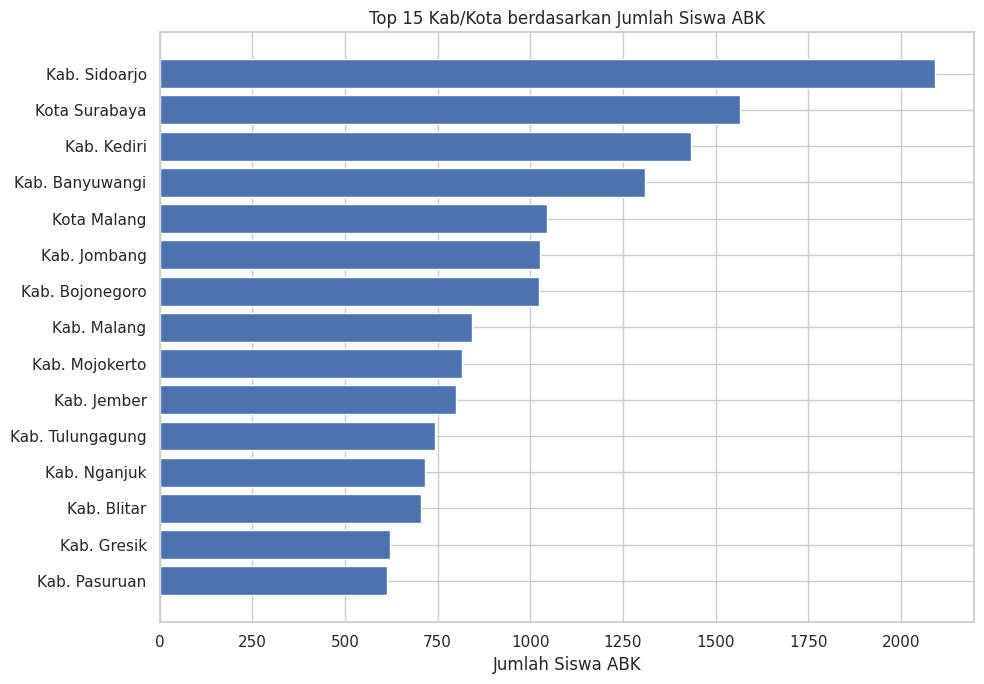

In [ ]:
# ============================================================
# 7) VISUALISASI
# ============================================================
# 7a. Barplot: Top 15 kab/kota jumlah siswa
plt.figure(figsize=(10,7))
tmp = agg.sort_values('students', ascending=False).head(15)
plt.barh(tmp['kabupaten/kota'], tmp['students'])
plt.gca().invert_yaxis()
plt.xlabel('Jumlah Siswa ABK')
plt.title('Top 15 Kab/Kota berdasarkan Jumlah Siswa ABK')
plt.tight_layout()
plt.show()

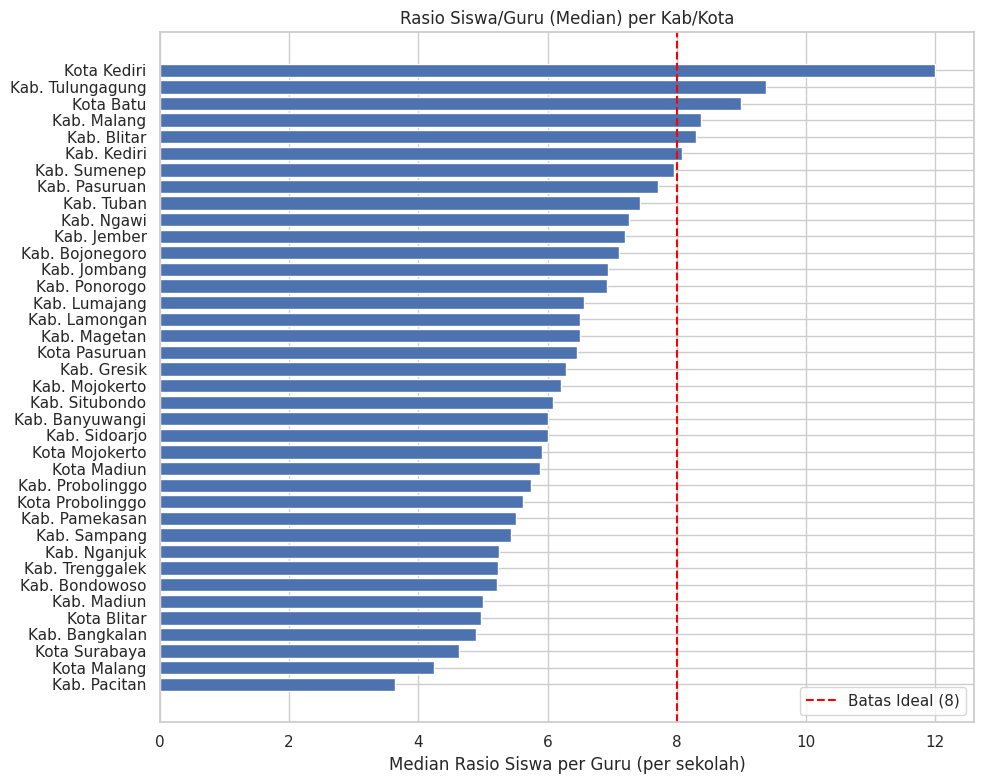

In [ ]:
# 7b. Barplot: Median rasio siswa/guru per kab/kota
plt.figure(figsize=(10,8))
tmp = agg.sort_values('median_ratio', ascending=False)
plt.barh(tmp['kabupaten/kota'], tmp['median_ratio'])
plt.axvline(IDEAL, color='red', linestyle='--', label='Batas Ideal (8)')
plt.gca().invert_yaxis()
plt.xlabel('Median Rasio Siswa per Guru (per sekolah)')
plt.title('Rasio Siswa/Guru (Median) per Kab/Kota')
plt.legend()
plt.tight_layout()
plt.show()

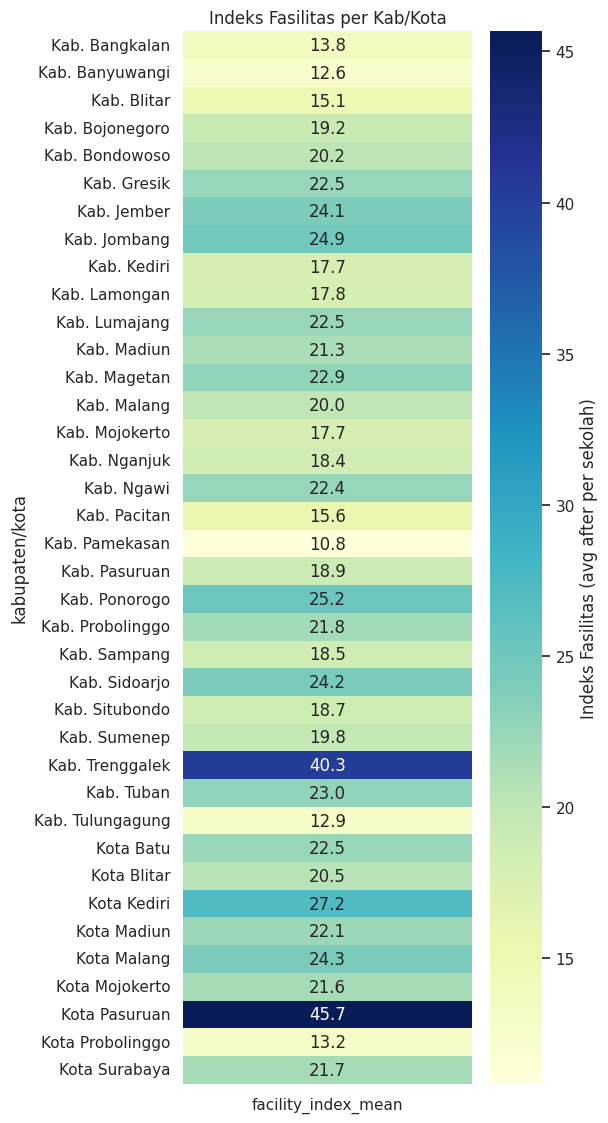

In [ ]:
# 7c. Heatmap: Indeks fasilitas rata-rata per kab/kota
plt.figure(figsize=(6, max(6, len(agg)*0.3)))
fac_mat = agg[['kabupaten/kota','facility_index_mean']].set_index('kabupaten/kota')
sns.heatmap(fac_mat, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label':'Indeks Fasilitas (avg after per sekolah)'})
plt.title('Indeks Fasilitas per Kab/Kota')
plt.tight_layout()
plt.show()

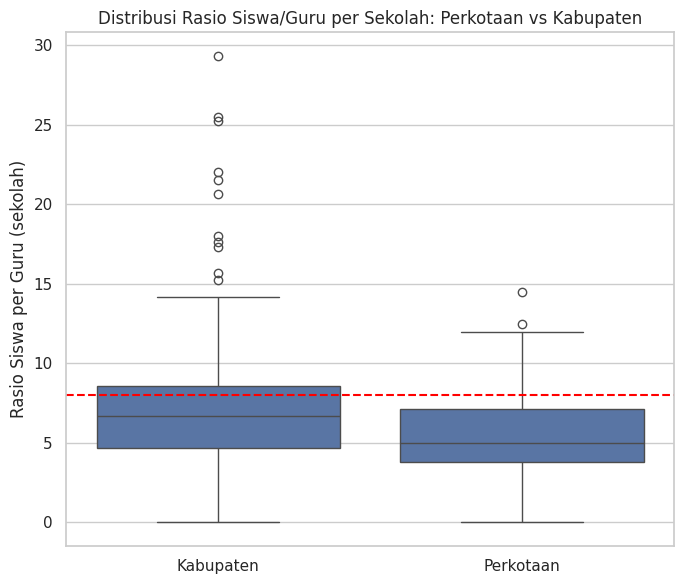

In [ ]:
# 7d. Boxplot: Rasio per sekolah, bandingkan Perkotaan vs Kabupaten
plt.figure(figsize=(7,6))
sns.boxplot(data=df, x='tipe_wilayah', y='ratio_school')
plt.axhline(IDEAL, color='red', linestyle='--')
plt.title('Distribusi Rasio Siswa/Guru per Sekolah: Perkotaan vs Kabupaten')
plt.xlabel('')
plt.ylabel('Rasio Siswa per Guru (sekolah)')
plt.tight_layout()
plt.show()

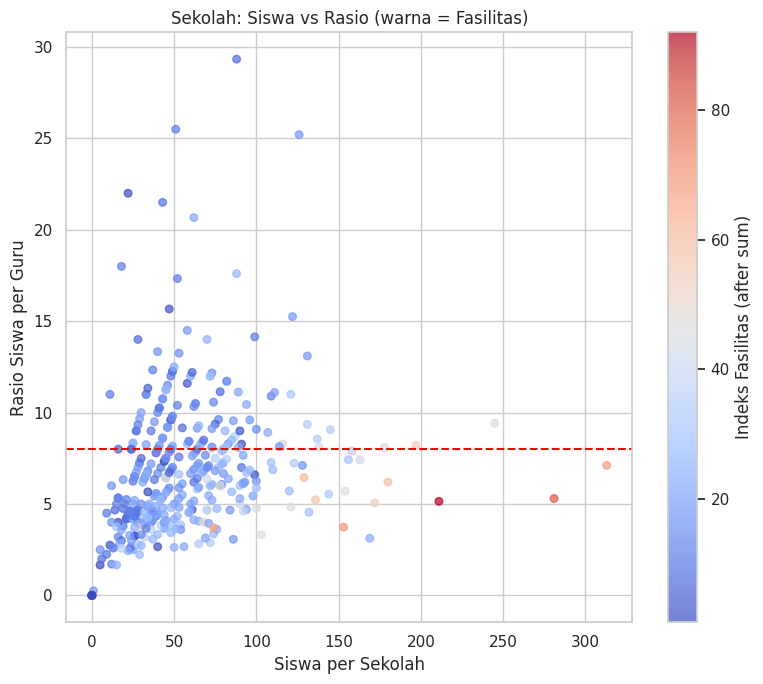

In [ ]:
# 7e. Scatter (sekolah): students vs ratio, warna = facility_index
plt.figure(figsize=(8,7))
sc = plt.scatter(df['students'], df['ratio_school'], c=df['facility_index_school'], cmap='coolwarm', s=30, alpha=0.7)
plt.colorbar(sc, label='Indeks Fasilitas (after sum)')
plt.axhline(IDEAL, color='red', linestyle='--')
plt.xlabel('Siswa per Sekolah')
plt.ylabel('Rasio Siswa per Guru')
plt.title('Sekolah: Siswa vs Rasio (warna = Fasilitas)')
plt.tight_layout()
plt.show()

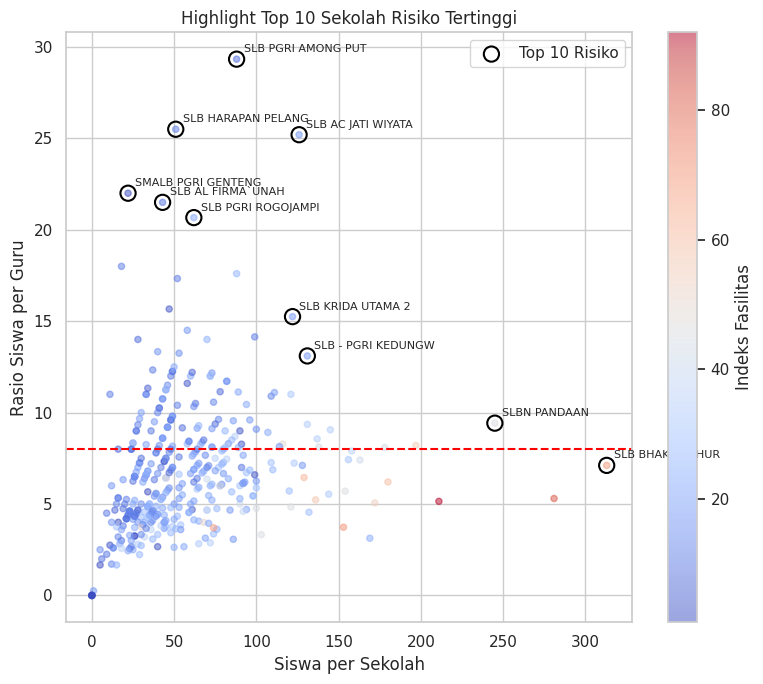

In [ ]:
# 7f. Labelkan Top 10 sekolah paling berisiko pada scatter (opsional)
plt.figure(figsize=(8,7))
sc = plt.scatter(df['students'], df['ratio_school'], c=df['facility_index_school'], cmap='coolwarm', s=20, alpha=0.5)
plt.colorbar(sc, label='Indeks Fasilitas')
plt.axhline(IDEAL, color='red', linestyle='--')
top = df.sort_values('risk_score_school', ascending=False).head(10)
plt.scatter(top['students'], top['ratio_school'], edgecolor='black', facecolor='none', s=120, linewidth=1.5, label='Top 10 Risiko')
for _, r in top.iterrows():
    plt.annotate(r['sekolah'][:18], (r['students'], r['ratio_school']), xytext=(5,5), textcoords='offset points', fontsize=8)
plt.xlabel('Siswa per Sekolah')
plt.ylabel('Rasio Siswa per Guru')
plt.title('Highlight Top 10 Sekolah Risiko Tertinggi')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# 8) OUTPUT TABEL RINGKASAN UTAMA
# ============================================================
print("\n=== RINGKASAN KAB/KOTA (utama) ===")
print(agg[['kabupaten/kota','num_schools','students','teachers','median_ratio','facility_index_mean','ratio_cv_sch','fac_cv_sch','needed_teachers_region']].sort_values('students', ascending=False).head(25))

print("\n=== TOP 10 SEKOLAH RISIKO TERTINGGI ===")
print(top10_schools[['kabupaten/kota','kecamatan','sekolah','students','teachers','ratio_school','facility_index_school','needed_teachers_school','surplus_teachers_school','risk_score_school']])

print("\n=== PRIORITAS INTERVENSI KAB/KOTA (TOP 15) ===")
print(priority_regions[['kabupaten/kota','num_schools','students','teachers','median_ratio','facility_index_mean','ratio_cv_sch','fac_cv_sch','needed_teachers_region','priority_score_region']].head(15))

print("\n=== REDISTRIBUSI GURU (CELAH SETELAH SURPLUS) – TOP 15 CELAH TERTINGGI ===")
print(realloc[['kabupaten/kota','needed_teachers_total','surplus_teachers_total','net_gap_after_realloc']].sort_values('net_gap_after_realloc', ascending=False).head(15))


=== RINGKASAN KAB/KOTA (utama) ===
      kabupaten/kota  num_schools  students  teachers  median_ratio  \
23     Kab. Sidoarjo           31      2093       369      6.000000   
37     Kota Surabaya           40      1567       310      4.625000   
8        Kab. Kediri           26      1435       200      8.083333   
1    Kab. Banyuwangi           43      1310       248      6.000000   
33       Kota Malang           14      1045       194      4.250000   
7       Kab. Jombang           16      1026       150      6.928571   
3    Kab. Bojonegoro           13      1024       147      7.111111   
13       Kab. Malang           13       842       110      8.375000   
14    Kab. Mojokerto           15       817       133      6.206897   
6        Kab. Jember           10       800       118      7.204545   
28  Kab. Tulungagung           12       742        93      9.375000   
15      Kab. Nganjuk           11       717       127      5.250000   
2        Kab. Blitar           11       7

In [ ]:
total_students_file = df['students'].sum()
print(f"Total jumlah siswa ABK di file data: {int(total_students_file)}")

Total jumlah siswa ABK di file data: 22597


In [ ]:
total_slb = df.shape[0]
print(f"Total jumlah SLB di file data: {total_slb}")

Total jumlah SLB di file data: 392


In [ ]:
# Hitung rasio guru per sekolah dengan perbandingan mengikuti aturan yang diberikan
import numpy as np # Pastikan numpy terimport jika belum
import pandas as pd # Pastikan pandas terimport jika belum

# Definisikan rasio ideal siswa per rombel berdasarkan bentuk pendidikan (mengacu pada teks aturan)
def get_ideal_students_per_rombel(bentuk_pendidikan):
    bentuk = str(bentuk_pendidikan).lower()
    if 'dasar luar biasa' in bentuk or 'sdlb' in bentuk:
        return 5 # 5 Peserta Didik per rombel untuk sekolah dasar luar biasa
    elif 'menengah pertama luar biasa' in bentuk or 'smplb' in bentuk:
        return 8 # 8 Peserta Didik per rombel untuk sekolah menengah pertama luar biasa
    elif 'menengah atas luar biasa' in bentuk or 'smalb' in bentuk:
        return 8 # 8 Peserta Didik per rombel untuk sekolah menengah atas luar biasa
    elif 'slb' in bentuk:
        # Untuk bentuk pendidikan 'SLB' umum yang mencakup berbagai jenjang (SD-SMA),
        # kita akan gunakan rasio ideal 8, mengikuti aturan untuk SMPLB dan SMALB.
        # Ini adalah pendekatan estimasi.
        return 8
    else:
        return np.nan

# Terapkan fungsi untuk mendapatkan rasio ideal siswa per rombel per sekolah
df['ideal_students_per_rombel'] = df['bentuk_pendidikan'].apply(get_ideal_students_per_rombel)

# Hitung rasio siswa per guru aktual per sekolah (menggunakan total siswa dan total guru)
df['actual_ratio_school'] = df.apply(lambda row: row['students'] / row['teachers'] if row['teachers'] > 0 else np.nan, axis=1)

# Hitung gap rasio (seperti sebelumnya) - ini membandingkan rasio siswa/guru aktual vs ideal siswa/rombel
# Nilai positif berarti rasio aktual lebih tinggi dari ideal (kurang guru)
# Nilai negatif berarti rasio aktual lebih rendah dari ideal (cukup/lebih guru)
df['ratio_gap_actual_vs_ideal_rombel'] = df['actual_ratio_school'] - df['ideal_students_per_rombel']


# Tampilkan data semua sekolah dengan kolom rasio yang relevan
print("\nRasio Guru per Sekolah (Aktual vs Ideal berdasarkan Aturan) untuk Semua Sekolah:")
display(df[['kabupaten/kota', 'sekolah', 'bentuk_pendidikan', 'students', 'teachers', 'rombel', 'actual_ratio_school', 'ideal_students_per_rombel', 'ratio_gap_actual_vs_ideal_rombel']])


Rasio Guru per Sekolah (Aktual vs Ideal berdasarkan Aturan) untuk Semua Sekolah:


,kabupaten/kota,sekolah,bentuk_pendidikan,students,teachers,rombel,actual_ratio_school,ideal_students_per_rombel,ratio_gap_actual_vs_ideal_rombel
0,Kab. Bangkalan,SLB SAMUDRA LAVENDER,SLB,99,15,13,6.600000,8,-1.400000
1,Kab. Bangkalan,SLB PGRI,SLB,36,5,11,7.200000,8,-0.800000
2,Kab. Bangkalan,SLB NEGERI KELEYAN BANGKALAN,SLB,50,19,33,2.631579,8,-5.368421
3,Kab. Bangkalan,SLB SAMUDRA TERRA ATHENA,SLB,16,5,6,3.200000,8,-4.800000
4,Kab. Banyuwangi,SLB PGRI BANGOREJO,SLB,72,12,13,6.000000,8,-2.000000
...,...,...,...,...,...,...,...,...,...
387,Kota Surabaya,SLB KHUSUS BINA MANDIRI,SLB,18,7,10,2.571429,8,-5.428571
388,Kota Surabaya,SDLB-B KARYA MULIA SURABAYA,SDLB,45,8,7,5.625000,5,0.625000
389,Kota Surabaya,SLB-B KARYA MULIA IV,SLB,13,5,5,2.600000,8,-5.400000
390,Kota Surabaya,SMALB-B KARYA MULIA,SMALB,40,12,12,3.333333,8,-4.666667


In [ ]:
# Modifikasi kolom 'bentuk_pendidikan' berdasarkan nama sekolah
def standardize_bentuk_pendidikan(row):
    sekolah_name = str(row['sekolah']).lower()
    bentuk_pendidikan_original = str(row['bentuk_pendidikan']).lower()

    # Priority 1: Use explicit bentuk_pendidikan if it's specific SLB level
    if 'dasar luar biasa' in bentuk_pendidikan_original or 'sdlb' in bentuk_pendidikan_original:
        return 'SDLB'
    elif 'menengah pertama luar biasa' in bentuk_pendidikan_original or 'smplb' in bentuk_pendidikan_original:
        return 'SMPLB'
    elif 'menengah atas luar biasa' in bentuk_pendidikan_original or 'smalb' in bentuk_pendidikan_original:
        return 'SMALB'
    # Priority 2: Infer from school name if bentuk_pendidikan is general 'SLB'
    elif 'slb' in bentuk_pendidikan_original: # Only process if original is a form of SLB
        if 'sdlb' in sekolah_name or 'sekolah dasar luar biasa' in sekolah_name:
            return 'SDLB'
        elif 'smplb' in sekolah_name or 'sekolah menengah pertama luar biasa' in sekolah_name:
            return 'SMPLB'
        elif 'smalb' in sekolah_name or 'sekolah menengah atas luar biasa' in sekolah_name:
            return 'SMALB'
        # If school name is just "SLB" or doesn't specify level, keep it as 'SLB'
        return 'SLB'

    # Keep original if it's not an SLB
    return row['bentuk_pendidikan']

# Apply the function to update the 'bentuk_pendidikan' column
df['bentuk_pendidikan_standardized'] = df.apply(standardize_bentuk_pendidikan, axis=1)

# Replace the original 'bentuk_pendidikan' with the standardized one
df['bentuk_pendidikan'] = df['bentuk_pendidikan_standardized']
df = df.drop(columns=['bentuk_pendidikan_standardized']) # Drop the temporary column

print("Kolom 'bentuk_pendidikan' telah diperbarui berdasarkan nama sekolah.")
display(df[['sekolah', 'bentuk_pendidikan']].head())
print("\nDistribusi bentuk pendidikan setelah standardisasi:")
display(df['bentuk_pendidikan'].value_counts())

Kolom 'bentuk_pendidikan' telah diperbarui berdasarkan nama sekolah.


,sekolah,bentuk_pendidikan
0,SLB SAMUDRA LAVENDER,SLB
1,SLB PGRI,SLB
2,SLB NEGERI KELEYAN BANGKALAN,SLB
3,SLB SAMUDRA TERRA ATHENA,SLB
4,SLB PGRI BANGOREJO,SLB



Distribusi bentuk pendidikan setelah standardisasi:


,count
bentuk_pendidikan,
SLB,347
SDLB,18
SMPLB,14
SMALB,13


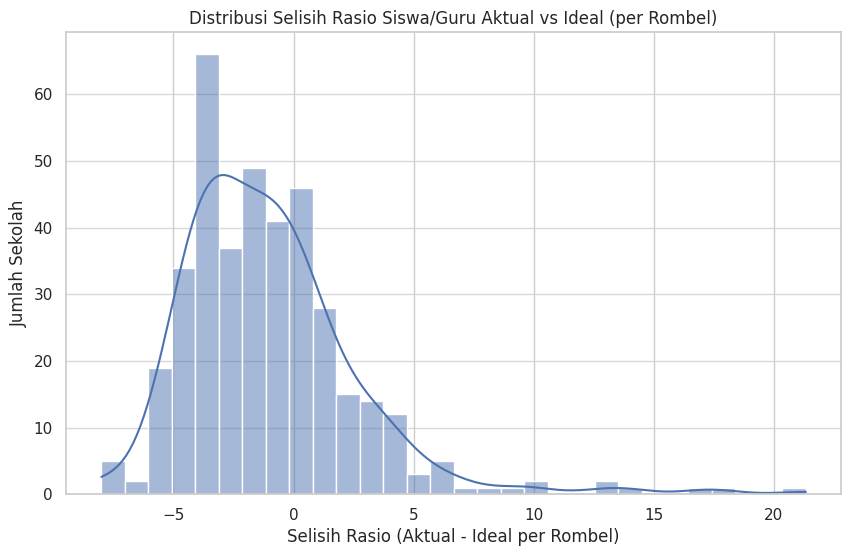

In [ ]:
# Visualisasi: Histogram dari ratio_gap_actual_vs_ideal_rombel
plt.figure(figsize=(10, 6))
sns.histplot(df['ratio_gap_actual_vs_ideal_rombel'].dropna(), bins=30, kde=True)
plt.title('Distribusi Selisih Rasio Siswa/Guru Aktual vs Ideal (per Rombel)')
plt.xlabel('Selisih Rasio (Aktual - Ideal per Rombel)')
plt.ylabel('Jumlah Sekolah')
plt.grid(axis='y', alpha=0.75)
plt.show()